# Example of the mlregressor() function

Author: Charles Le Losq

The mlregressor function actually calls the 'rampy.mlregressor' class.
        
This is for convenience, as this offer a high level API to Scikit-Learn within Julia.
            
For any more evolved things, you can turn to Flux.jl for neural nets for instance.
        
'mlregressor' performs automatic data scaling, hyperparameter grid search and provides access to popular algorithms (Support Vector, Kernel Ridge, Neural Nets...) for using machine learning in a regression task implying spectroscopic data. This function allows one to link any variable to a set of spectra with using a machine learning technique.

Let's assume for the sack of example that we observe spectra D that are the combination of $k$ endmember spectra S with concentrations C, such that:
$ D_{i,j} = C_{i,k} \times S_{k,j} $

Here we assume a linear combination. In Python, assuming that the partial spectra are simple Gaussians, we can write the following.


In [1]:
using Spectra, PyPlot

# Machine Learning

We can train a machine learning algorithm to follow changes in D as a function of C, assuming we measured both quantities.

mlregressor uses scikit_learn algorithms to do so in a easy way, with under-the-hood standardization and cross-validation. This is to use for "simple" projects, while more complicated things will required an ad hoc approach, directly using scikit-learn or any other relevant ML library.

For now, we will show how we can train neural networks to link D and C, such that we can predict C from new observations of D.

First dim should be equalt to nbexp = 1000


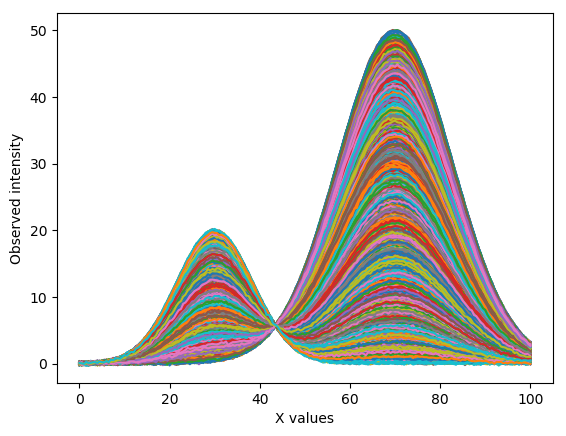

(1000, 201)


In [2]:
#
# Generating fake data
#

x = collect(0:0.5:100)
~, prs = gaussiennes([20.,50.],[30.,70.],[10.,15.],x)

nbexp = 1000

C = rand(nbexp)
C = [C 1.0.-C]

D = C*prs' .+0.1.*randn(size(C*prs'))

#
# Plot
#

plot(x,D')

xlabel("X values")
ylabel("Observed intensity")

println("First dim should be equalt to nbexp = $(nbexp)")
println(size(D))

# Choice of the algorithm

Many popular algorithms are possible: KernelRidge, SVM, LinearRegression, Lasso, ElasticNet, NeuralNet, BaggingNeuralNet.

LinearRegression, Lasso and ElasticNet are borned to linear problems, while KernelRidge, SVM, NeuralNet or BaggingNeuralNet can do both linear and non-linear problems. See the documentation of scikit-learn for further details, and all the articles online on those techniques. Those techniques need hyperparameters that are provided as a dictionary to rampy.mlregressor. I strongly encourage you to read the documentation on scikit-learn for the technique you want to use, in order to set those hyperparameters in the good range.

In the present case, we are dealing with a linear problem. We thus can use the Lasso or ElasticNet algorithms.

Machine learning algorithms need a training dataset, and their performance is evaluated on a "testing" dataset that is unseen of the algorithm. rp.mlregressor can split your dataset automatically, or you can choose to provide the two different datasets. Parameters for each algorithm are provided as a dictionary, see the documentation of scikit-learn for further details on them. The datasets are also standardized/normalised inside the function (if you don't know what this means, click here). The type of scaling is changed by the scaler option.

rp.mlregressor creates an object that possess many attributes that are set by default but can be tweaked as preferred. The object also possess two methods: fit and predict, similar to the scikit-learn API. However, contrary to scikit-learn and due to the aim of the rampy.mlregressor class, the dataset is loaded upon initialisation of the object. Fit is performed at a second stage as one can switch easily between different algorithms.

The predict function works as that of a scikit-learn model, predicting new values from a new X dataset. Scaling is performed if rampy.mlregressor.scaling is set to True.

For now, we are going to load our data and create our mlregressor object:


In [3]:
model = mlregressor(D,C[:,1])

PyObject <rampy.ml_regressor.mlregressor object at 0x7fd173ca2ba8>

This default implementation takes care of splitting the dataset in training and testing subsets in a ratio 70/30, then scaled it with a standard scaler. The test size can be seen (and then set) as:

In [4]:
model.test_sz

0.3

The scaler is accessed as

In [5]:
model.scaler

"MinMaxScaler"

Is scaling active?

In [6]:
model.scaling

true

Let's try a quick fit with a few models

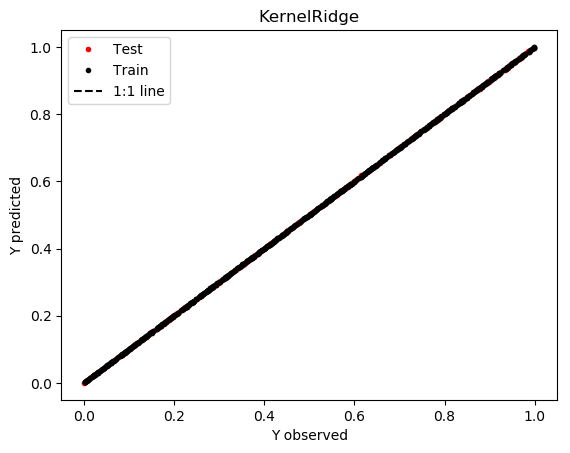

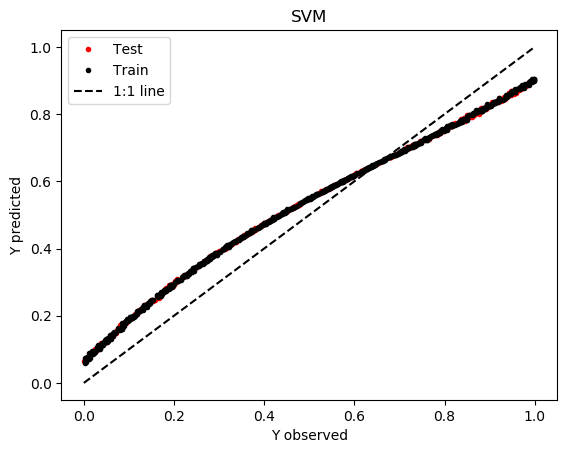

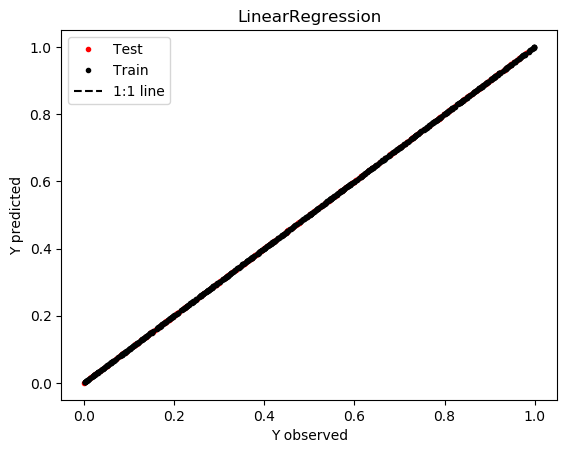

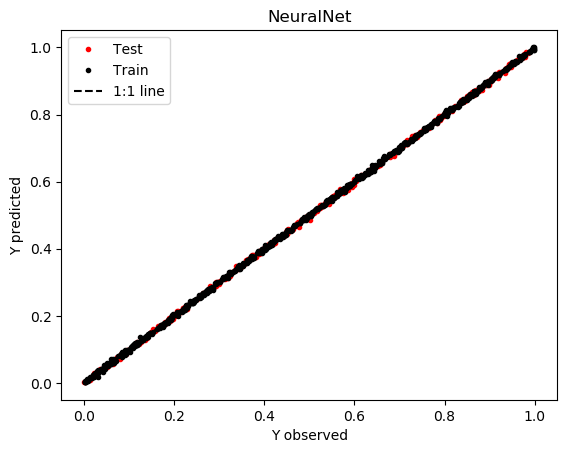

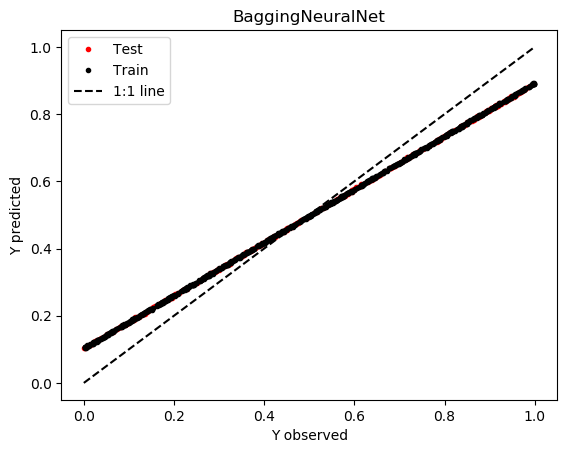

In [7]:
for i in ["KernelRidge", "SVM", "LinearRegression", "NeuralNet", "BaggingNeuralNet"]
    model.algorithm = i
    model.user_kernel = "poly"
    model.fit()
    figure()
    title(model.algorithm)
    plot(model.y_test,model.prediction_test,"r.",label="Test")
    plot(model.y_train,model.prediction_train,"k.",label="Train")
    xlabel("Y observed")
    ylabel("Y predicted")
    plot([0,1],[0,1],"k--",label="1:1 line")
    legend()

end
    

Of course we probably can get better results if tuning the model hyper parameters! For instance the support vector machine algorithm did not work well. We can try using a linear kernel, as the default one is set to radial basis function:

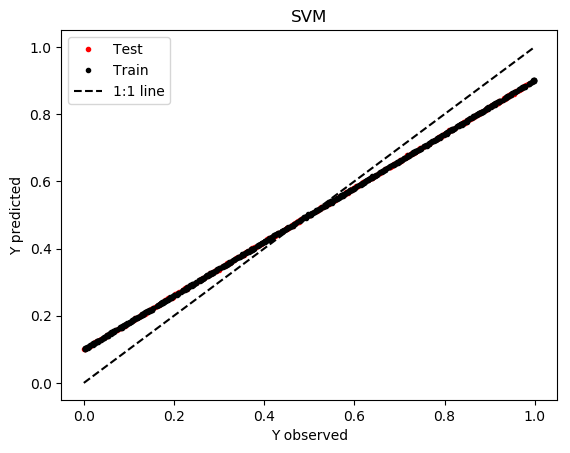

PyObject <matplotlib.legend.Legend object at 0x7fd1717b7ef0>

In [8]:
model.algorithm = "SVM"
model.user_kernel = "linear"
model.param_grid_svm = Dict("C"=> exp10.(range(-5, stop=5, length=40)), "gamma"=> exp10.(range(-5, stop=5, length=40)))
model.fit()

figure()
title(model.algorithm)
plot(model.y_test,model.prediction_test,"r.",label="Test")
plot(model.y_train,model.prediction_train,"k.",label="Train")
plot([0,1],[0,1],"k--",label="1:1 line")
xlabel("Y observed")
ylabel("Y predicted")
legend()

Not really better. Maybe SVM is not the best technique for this problem, or we have a problem in the hyperparameters...

Let's try other algorithms, like neural nets and their ensemble version.

# Neural Nets

We see above that our ensemble method that trains 100 neural nets and get an estimate from their mean. It seems to work well. We can play with the hyperparameters.

First, we now train 1000 networks, not 100, by setting n_estimators to 1000.

We also tune the architecture of the network, by putting 10 activation functions in a single hidden layer.


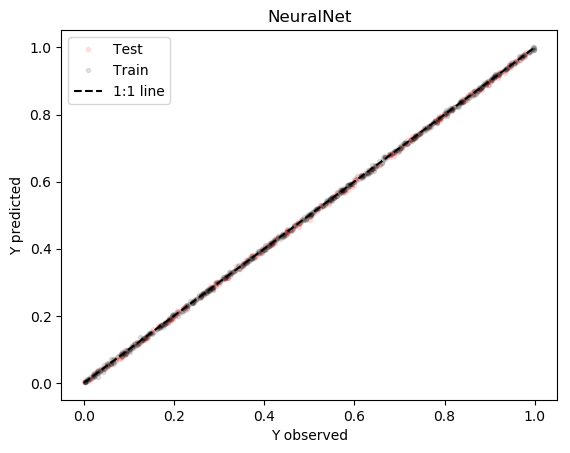

Shape of the hidden layers: (3,)
Activation functions in the hidden layers: relu


PyObject <matplotlib.legend.Legend object at 0x7fd17186f9e8>

In [9]:
model.algorithm = "NeuralNet"
model.param_neurons["hidden_layer_sizes"] = (10,) 
model.param_neurons["activation"] = "tanh" # we also could try changing the activation to tanh. Try it!
model.param_bagging = Dict("n_estimators"=>1000, 
                            "max_samples"=>100)

println("Shape of the hidden layers: $(model.param_neurons["hidden_layer_sizes"])")
println("Activation functions in the hidden layers: $(model.param_neurons["activation"])")

model.fit()
figure()
title(model.algorithm)
plot(model.y_test,model.prediction_test,"r.",alpha=0.1,label="Test")
plot(model.y_train,model.prediction_train,"k.",alpha=0.1,label="Train")
plot([0,1],[0,1],"k--",label="1:1 line")
xlabel("Y observed")
ylabel("Y predicted")
legend()

# New observations and predictions!

We can generate new C values and see if our model predicts them well.

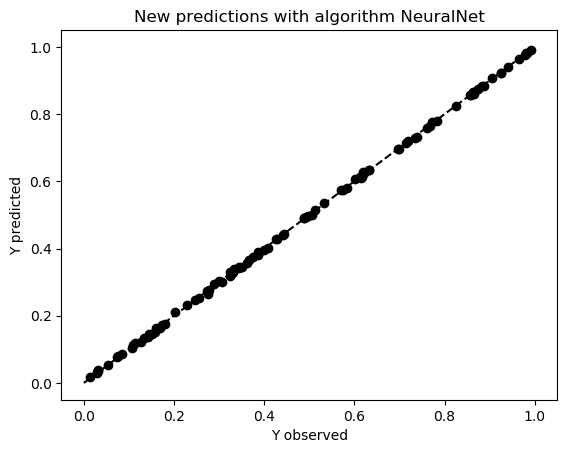

PyObject Text(24,0.5,'Y predicted')

In [12]:
C_new = rand(100)
C_new = [C_new 1.0.-C_new]

D_new = C_new*prs' .+0.1.*randn(size(C_new*prs'))

C_new_predicted = model.predict(D_new);

figure()
title("New predictions with algorithm $(model.algorithm)")
plot(C_new[:,1],C_new_predicted,"ko")
plot([0,1],[0,1],"k--",label="1:1 line")
xlabel("Y observed")
ylabel("Y predicted")